# Benchmarking Matrix generation script

Important remarks :

- Approximation results as the load of the active ui animation is hard to simulate aside the matrix calculation. Currently a large animation with 0.5 boat is run beside this script

- Number of time deltas per combination is chosen arbitrarily, 10 in this case, for the sake of simplicity, it is totally possible for a data to be more heavy on a specific time range that may not be covered in the selected deltas

In [12]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

In [13]:

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb


In [14]:


"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'processed_data',
                'MMSI',
                'traj']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.008042335510253906 seconds, 0.2412700653076172 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 10 created in 0.0009741783142089844 seconds, 0.02922534942626953 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 20 created in 0.001064300537109375 seconds, 0.03192901611328125 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 30 created in 0.010788679122924805 seconds, 0.32366037368774414 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 40 created in 0.0010080337524414062 seconds, 0.030241012573242188 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 50 created in 0.000980377197265625 seconds, 0.02941131591796875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.010985374450683594 seconds, 0.3295612335205078 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 70 created in 0.0009667873382568359 seconds, 0.029003620147705078 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 80 created in 0.0010418891906738281 seconds, 0.031256675720214844 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:02<00:48,  2.87s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 90 created in 0.012847900390625 seconds, 0.38543701171875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.04988217353820801 seconds, 1.4964652061462402 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 10 created in 0.003160715103149414 seconds, 0.09482145309448242 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 20 created in 0.004606008529663086 seconds, 0.13818025588989258 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 30 created in 0.06655669212341309 seconds, 1.9967007637023926 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 40 created in 0.003551483154296875 seconds, 0.10654449462890625 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 50 created in 0.0037813186645507812 seconds, 0.11343955993652344 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.08076882362365723 seconds, 2.423064708709717 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 70 created in 0.003302335739135742 seconds, 0.09907007217407227 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 80 created in 0.003278493881225586 seconds, 0.09835481643676758 frames for 30 fps animation.\n', stderr='')


Combination (10, 1):  11%|█         | 2/18 [00:06<00:56,  3.51s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 90 created in 0.08130598068237305 seconds, 2.4391794204711914 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.12597370147705078 seconds, 3.7792110443115234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 10 created in 0.006909608840942383 seconds, 0.20728826522827148 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 20 created in 0.0055294036865234375 seconds, 0.16588211059570312 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 30 created in 0.14950156211853027 seconds, 4.485046863555908 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 40 created in 0.006146669387817383 seconds, 0.18440008163452148 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 50 created in 0.0066432952880859375 seconds, 0.19929885864257812 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.15727949142456055 seconds, 4.718384742736816 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 70 created in 0.005529642105102539 seconds, 0.16588926315307617 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 80 created in 0.005564451217651367 seconds, 0.16693353652954102 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):  17%|█▋        | 3/18 [00:12<01:04,  4.31s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 90 created in 0.16145801544189453 seconds, 4.843740463256836 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.009861230850219727 seconds, 0.2958369255065918 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.013425350189208984 seconds, 0.40276050567626953 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 0.016887903213500977 seconds, 0.5066370964050293 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 180 created in 0.016588926315307617 seconds, 0.4976677894592285 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 0.022429227828979492 seconds, 0.6728768348693848 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 300 created in 0.01832270622253418 seconds, 0.5496811866760254 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 0.017744779586791992 seconds, 0.5323433876037598 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 420 created in 0.021287202835083008 seconds, 0.6386160850524902 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 0.018812179565429688 seconds, 0.5643653869628906 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.5):  22%|██▏       | 4/18 [00:15<00:53,  3.85s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 540 created in 0.0204010009765625 seconds, 0.612030029296875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.062334299087524414 seconds, 1.8700289726257324 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.09801959991455078 seconds, 2.9405879974365234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 0.1006615161895752 seconds, 3.019845485687256 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 180 created in 0.10773015022277832 seconds, 3.2319045066833496 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 0.10650372505187988 seconds, 3.1951117515563965 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 300 created in 0.10854053497314453 seconds, 3.256216049194336 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 0.11835002899169922 seconds, 3.5505008697509766 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 420 created in 0.11763262748718262 seconds, 3.5289788246154785 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 0.13136553764343262 seconds, 3.9409661293029785 frames for 30 fps animation.\n', stderr='')


Combination (60, 1):  28%|██▊       | 5/18 [00:20<00:54,  4.23s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 540 created in 0.11931657791137695 seconds, 3.5794973373413086 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.12990736961364746 seconds, 3.897221088409424 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 60 created in 0.1949911117553711 seconds, 5.849733352661133 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 0.2073969841003418 seconds, 6.221909523010254 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 180 created in 0.2145533561706543 seconds, 6.436600685119629 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 0.21842002868652344 seconds, 6.552600860595703 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 300 created in 0.22309303283691406 seconds, 6.692790985107422 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 0.22186589241027832 seconds, 6.65597677230835 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 420 created in 0.23793363571166992 seconds, 7.138009071350098 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 0.22647976875305176 seconds, 6.794393062591553 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.1):  33%|███▎      | 6/18 [00:27<01:02,  5.17s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 540 created in 0.24545860290527344 seconds, 7.363758087158203 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.09502887725830078 seconds, 2.8508663177490234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 0.17671823501586914 seconds, 5.301547050476074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 0.18115854263305664 seconds, 5.434756278991699 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 0.1970658302307129 seconds, 5.911974906921387 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 0.21249866485595703 seconds, 6.374959945678711 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 600 created in 0.22167754173278809 seconds, 6.650326251983643 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 0.22259950637817383 seconds, 6.677985191345215 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 840 created in 0.21651530265808105 seconds, 6.495459079742432 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 0.22570133209228516 seconds, 6.771039962768555 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.5):  39%|███▉      | 7/18 [00:31<00:55,  5.06s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1080 created in 0.23549342155456543 seconds, 7.064802646636963 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.7037453651428223 seconds, 21.112360954284668 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 1.1392145156860352 seconds, 34.176435470581055 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 1.26322340965271 seconds, 37.8967022895813 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 1.3292505741119385 seconds, 39.877517223358154 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 1.3550159931182861 seconds, 40.650479793548584 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 600 created in 1.3634355068206787 seconds, 40.90306520462036 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 1.4103481769561768 seconds, 42.3104453086853 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 840 created in 1.3975801467895508 seconds, 41.92740440368652 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 1.4822144508361816 seconds, 44.46643352508545 frames for 30 fps animation.\n', stderr='')


Combination (120, 1):  44%|████▍     | 8/18 [00:49<01:28,  8.88s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1080 created in 1.4454452991485596 seconds, 43.36335897445679 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 1.5884506702423096 seconds, 47.65352010726929 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 120 created in 2.641906261444092 seconds, 79.25718784332275 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 2.7860000133514404 seconds, 83.58000040054321 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 360 created in 3.010378122329712 seconds, 90.31134366989136 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 2.9204485416412354 seconds, 87.61345624923706 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 600 created in 2.874382257461548 seconds, 86.23146772384644 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 2.9401345252990723 seconds, 88.20403575897217 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 840 created in 2.9223756790161133 seconds, 87.6712703704834 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 2.904082775115967 seconds, 87.122483253479 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.1):  50%|█████     | 9/18 [01:22<02:28, 16.48s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1080 created in 2.9748456478118896 seconds, 89.24536943435669 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.342205286026001 seconds, 10.26615858078003 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 0.5790565013885498 seconds, 17.371695041656494 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 0.5577998161315918 seconds, 16.733994483947754 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 0.6034913063049316 seconds, 18.10473918914795 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 0.6686370372772217 seconds, 20.05911111831665 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1200 created in 0.6292152404785156 seconds, 18.87645721435547 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 0.701871395111084 seconds, 21.05614185333252 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1680 created in 0.7309401035308838 seconds, 21.928203105926514 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 0.7006592750549316 seconds, 21.01977825164795 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.5):  56%|█████▌    | 10/18 [01:31<01:54, 14.26s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2160 created in 0.6902332305908203 seconds, 20.70699691772461 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 2.4733970165252686 seconds, 74.20191049575806 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 3.6858506202697754 seconds, 110.57551860809326 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 3.796482801437378 seconds, 113.89448404312134 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 3.805697441101074 seconds, 114.17092323303223 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 3.8037619590759277 seconds, 114.11285877227783 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1200 created in 3.8571321964263916 seconds, 115.71396589279175 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 3.9653842449188232 seconds, 118.9615273475647 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1680 created in 3.9521212577819824 seconds, 118.56363773345947 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 4.129118204116821 seconds, 123.87354612350464 frames for 30 fps animation.\n', stderr='')


Combination (240, 1):  61%|██████    | 11/18 [02:13<02:39, 22.84s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2160 created in 4.122082233428955 seconds, 123.66246700286865 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 5.257841110229492 seconds, 157.73523330688477 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 240 created in 7.028390169143677 seconds, 210.8517050743103 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 7.319413661956787 seconds, 219.5824098587036 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 720 created in 7.464830636978149 seconds, 223.94491910934448 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 7.748982906341553 seconds, 232.46948719024658 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1200 created in 7.7251622676849365 seconds, 231.7548680305481 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 7.741875171661377 seconds, 232.2562551498413 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1680 created in 7.930842638015747 seconds, 237.9252791404724 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 7.905339479446411 seconds, 237.16018438339233 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.1):  67%|██████▋   | 12/18 [03:34<04:03, 40.55s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2160 created in 8.2229323387146 seconds, 246.687970161438 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 0.939232587814331 seconds, 28.17697763442993 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 1.2849822044372559 seconds, 38.549466133117676 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 1.4137330055236816 seconds, 42.41199016571045 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 1.5401058197021484 seconds, 46.20317459106445 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 1.589803695678711 seconds, 47.69411087036133 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2400 created in 1.7718477249145508 seconds, 53.15543174743652 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 1.5822627544403076 seconds, 47.46788263320923 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3360 created in 1.6644275188446045 seconds, 49.932825565338135 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 1.6987578868865967 seconds, 50.9627366065979 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.5):  72%|███████▏  | 13/18 [03:53<02:49, 33.83s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4320 created in 1.6638312339782715 seconds, 49.914937019348145 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 6.817068099975586 seconds, 204.51204299926758 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 8.617111921310425 seconds, 258.51335763931274 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 8.771231651306152 seconds, 263.13694953918457 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 8.938350915908813 seconds, 268.1505274772644 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 9.044400691986084 seconds, 271.3320207595825 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2400 created in 9.255851984024048 seconds, 277.67555952072144 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 9.462795734405518 seconds, 283.8838720321655 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3360 created in 9.256741762161255 seconds, 277.70225286483765 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 9.488587617874146 seconds, 284.65762853622437 frames for 30 fps animation.\n', stderr='')


Combination (480, 1):  78%|███████▊  | 14/18 [05:28<03:29, 52.34s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4320 created in 9.597070932388306 seconds, 287.91212797164917 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 13.629338026046753 seconds, 408.8801407814026 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 480 created in 16.943809509277344 seconds, 508.3142852783203 frames for

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 17.290041208267212 seconds, 518.7012362480164 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1440 created in 18.625642776489258 seconds, 558.7692832946777 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 18.36683750152588 seconds, 551.0051250457764 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2400 created in 18.450204372406006 seconds, 553.5061311721802 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 19.186251878738403 seconds, 575.5875563621521 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3360 created in 19.09444546699524 seconds, 572.8333640098572 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 19.897770166397095 seconds, 596.9331049919128 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4320 created in 20.13096594810486 seconds, 603.9289784431458 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.1):  83%|████████▎ | 15/18 [08:39<04:42, 94.07s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 2.4487993717193604 seconds, 73.46398115158081 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 3.186013698577881 seconds, 95.58041095733643 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 3.4709088802337646 seconds, 104.12726640701294 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 3.5394792556762695 seconds, 106.18437767028809 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 3.6297473907470703 seconds, 108.89242172241211 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4800 created in 3.646977663040161 seconds, 109.40932989120483 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 5760 created in 3.802767515182495 seconds, 114.08302545547485 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 6720 created in 3.9283716678619385 seconds, 117.85115003585815 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 7680 created in 3.952101469039917 seconds, 118.56304407119751 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.5):  89%|████████▉ | 16/18 [09:18<02:35, 77.60s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 8640 created in 4.005200624465942 seconds, 120.15601873397827 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 16.612842321395874 seconds, 498.3852696418762 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 20.064164876937866 seconds, 601.924946308136 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 21.20224642753601 seconds, 636.0673928260803 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 20.732313871383667 seconds, 621.96941614151 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 21.203473329544067 seconds, 636.104199886322 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4800 created in 21.323930740356445 seconds, 639.7179222106934 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 5760 created in 21.522337675094604 seconds, 645.6701302528381 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 6720 created in 21.71654176712036 seconds, 651.4962530136108 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 7680 created in 21.989028453826904 seconds, 659.6708536148071 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 8640 created in 22.46551537513733 seconds, 673.9654612541199 frames for 30 fps animation.\n', stderr='')


Combination (960, 1):  94%|█████████▍| 17/18 [12:55<01:59, 119.56s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 0 created in 33.09465575218201 seconds, 992.8396725654602 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 960 created in 40.648141384124756 seconds, 1219.4442415237427 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 1920 created in 41.89682340621948 seconds, 1256.9047021865845 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 2880 created in 43.18048119544983 seconds, 1295.4144358634949 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 3840 created in 43.08843111991882 seconds, 1292.6529335975647 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 4800 created in 44.89553427696228 seconds, 1346.8660283088684 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 5760 created in 43.93466854095459 seconds, 1318.0400562286377 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 6720 created in 44.21336913108826 seconds, 1326.4010739326477 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 7680 created in 44.63840079307556 seconds, 1339.1520237922668 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'processed_data', 'MMSI', 'traj'], returncode=0, stdout='================================================================     Matrix 8640 created in 45.66104531288147 seconds, 1369.831359386444 frames for 30 fps animation.\n', stderr='')


Combination (960, 1): 100%|██████████| 18/18 [20:15<00:00, 67.53s/it] 


In [15]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}

In [16]:
memory_used

{(10, 0.1): 0.35426807403564453,
 (10, 0.5): 1.7835121154785156,
 (10, 1): 3.580728530883789,
 (60, 0.1): 2.110030174255371,
 (60, 0.5): 10.569404602050781,
 (60, 1): 21.157538414001465,
 (120, 0.1): 5.067878723144531,
 (120, 0.5): 26.168395042419434,
 (120, 1): 53.07246017456055,
 (240, 0.1): 11.448563575744629,
 (240, 0.5): 59.421494483947754,
 (240, 1): 121.17325210571289,
 (480, 0.1): 24.267576217651367,
 (480, 0.5): 126.2737226486206,
 (480, 1): 257.8971691131592,
 (960, 0.1): 51.535221099853516,
 (960, 0.5): 272.4908838272095,
 (960, 1): 554.2542095184326}

# Average time to generate T delta per combination

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage           
10     0.1          0.284480
       0.5          0.392796
       1.0          0.523197
60     0.1          0.310346
       0.5          0.486491
       1.0          0.697996
120    0.1          0.479620
       0.5          1.702974
       1.0          3.314045
240    0.1          0.926505
       0.5          4.226867
       1.0          8.102595
480    0.1          1.834124
       0.5          9.505630
       1.0         19.074064
960    0.1          3.931944
       0.5         21.709961
       1.0         43.983634

In [35]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                      
Percentage       0.1        0.5        1.0
Frames                                    
10          0.284480   0.392796   0.523197
60          0.310346   0.486491   0.697996
120         0.479620   1.702974   3.314045
240         0.926505   4.226867   8.102595
480         1.834124   9.505630  19.074064
960         3.931944  21.709961  43.983634

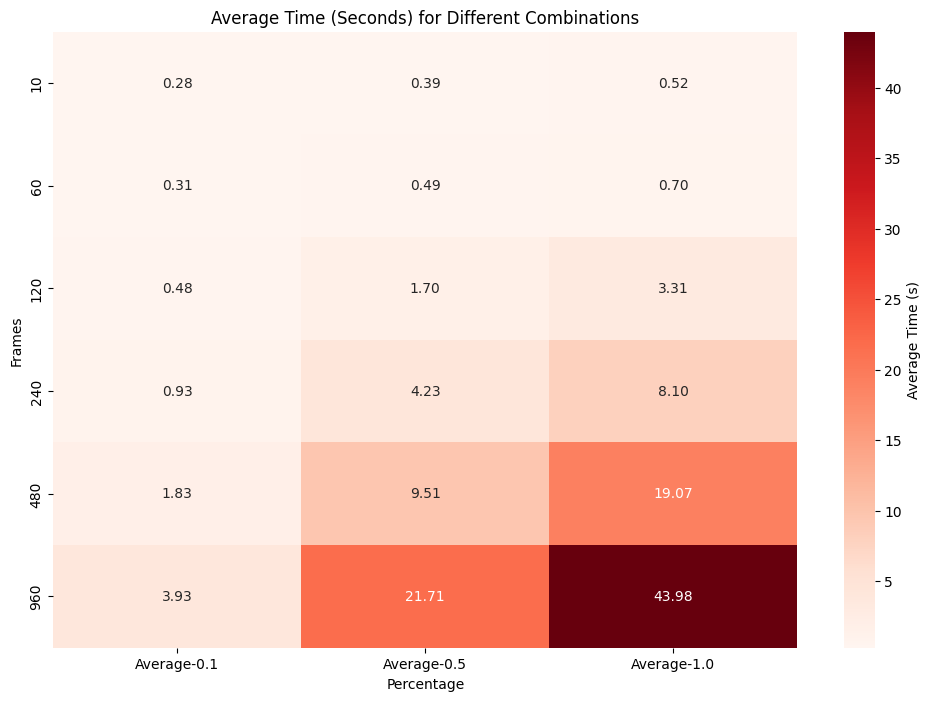

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# MAX FPS for uninterrupted animation per combinations

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$



In [21]:
max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values

{(10, 0.1): 32.84310293929948,
 (10, 0.5): 21.537780557528254,
 (10, 1): 15.951745094832603,
 (60, 0.1): 156.64971680725154,
 (60, 0.5): 118.68729033502535,
 (60, 1): 81.81118473280657,
 (120, 0.1): 234.39537241471487,
 (120, 0.5): 62.737241030382755,
 (120, 1): 33.70842331383872,
 (240, 0.1): 229.44053761997313,
 (240, 0.5): 52.057357199776156,
 (240, 1): 26.924021140201113,
 (480, 0.1): 228.3147415025798,
 (480, 0.5): 46.987803269359006,
 (480, 1): 22.63313846148173,
 (960, 0.1): 220.05275103385446,
 (960, 0.5): 41.221335568696524,
 (960, 1): 20.31889354268247}

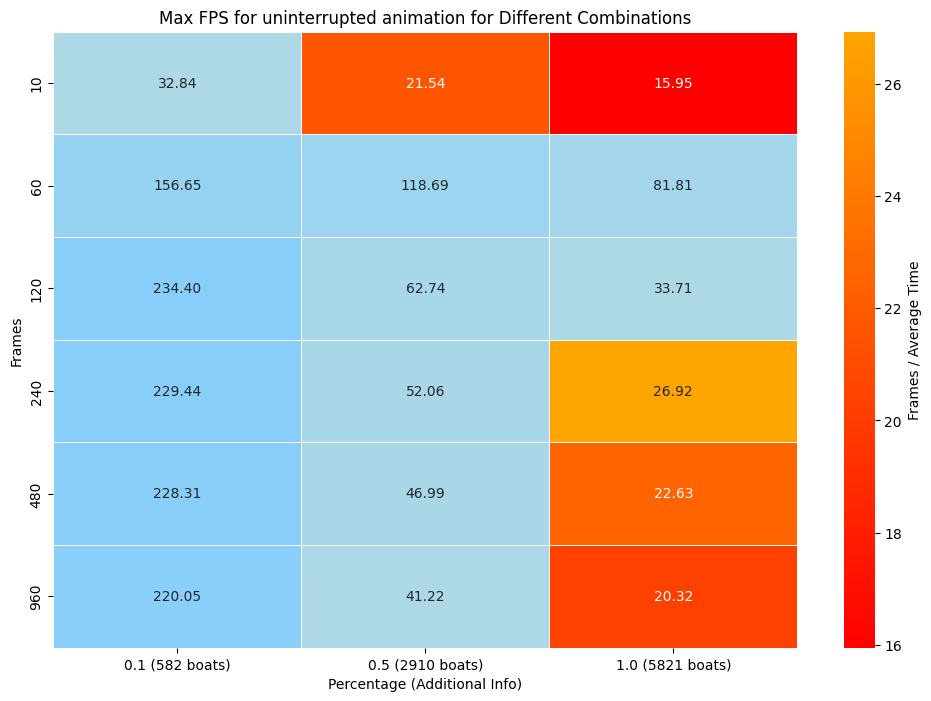

In [28]:
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied on disk by 3 matrices (t-1, t, t+1)

In [29]:
memory_used

{(10, 0.1): 0.35426807403564453,
 (10, 0.5): 1.7835121154785156,
 (10, 1): 3.580728530883789,
 (60, 0.1): 2.110030174255371,
 (60, 0.5): 10.569404602050781,
 (60, 1): 21.157538414001465,
 (120, 0.1): 5.067878723144531,
 (120, 0.5): 26.168395042419434,
 (120, 1): 53.07246017456055,
 (240, 0.1): 11.448563575744629,
 (240, 0.5): 59.421494483947754,
 (240, 1): 121.17325210571289,
 (480, 0.1): 24.267576217651367,
 (480, 0.5): 126.2737226486206,
 (480, 1): 257.8971691131592,
 (960, 0.1): 51.535221099853516,
 (960, 0.5): 272.4908838272095,
 (960, 1): 554.2542095184326}

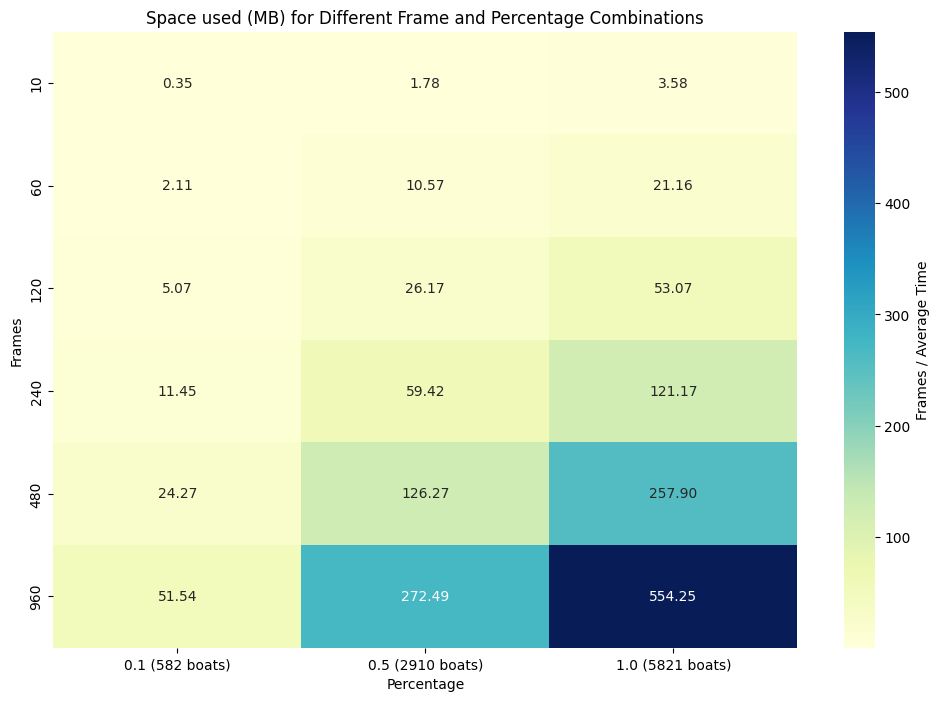

In [30]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()